In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from segmentflow import segment, view
from skimage import transform

In [6]:
user = (
    'cgusb' if 'cgusb' in [f.stem for f in Path(r"C:\Users").iterdir()]
    else 'gusb'
)
img_dir = Path(
    fr'C:\Users\{user}\Research\mhe-analysis\data\IDOX_prill_1'
    fr'\prill_1_no_compression'
)
file_suffix = '.tiff'
# imgs = segment.load_images(img_dir)

In [8]:
def save_rescaled(img_dir, new_dir_path, file_suffix='.tiff', scale=0.5):
    Path(new_dir_path).mkdir(exist_ok=False)
    img_path_list = [
        path for path in Path(img_dir).glob(f'*{file_suffix}')
    ]
    n_rescaled = int(len(img_path_list) * scale)
    n_digits = len(str(n_rescaled))
    for i, img_path in enumerate(img_path_list[::int(1/scale)]):
        img = iio.imread(img_path)
        img = transform.rescale(img, scale, anti_aliasing=False)
        iio.imwrite(
            Path(new_dir_path) / (
                f'rescaled_{str(i).zfill(n_digits)}.{file_suffix}'
            ), img
        )
    print(f'{i} image(s) saved:')
    print(new_dir_path)

scale = 0.25
rescaled_img_dir = Path(img_dir).parent / f'prill_1_{scale}-scale'
# save_rescaled(img_dir, rescaled_img_dir, scale=0.25)

Loading images...
--> Images loaded as 3D array:  (498, 508, 496)
--> Plotting images: [100, 250, 400]


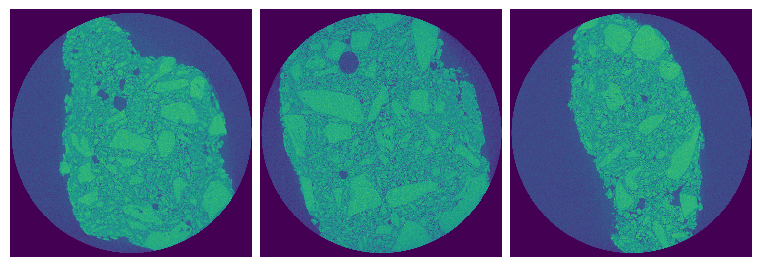

In [ ]:
slices = [100, 250, 400]
imgs = segment.load_images(rescaled_img_dir)
view.vol_slices(imgs, slices=slices)
plt.show()

Generating histogram...


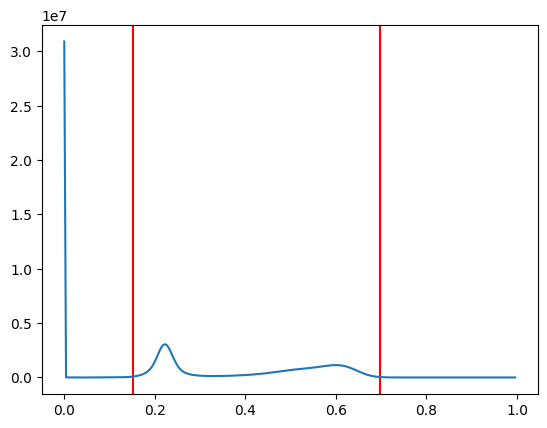

In [16]:
rescale_range = [25, 99.9]
fig, ax = view.histogram(
    imgs, mark_percentiles=rescale_range
)

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [25, 99.9]...
--> Preprocessing complete.
--> Plotting images: [100, 250, 400]
Generating histogram...


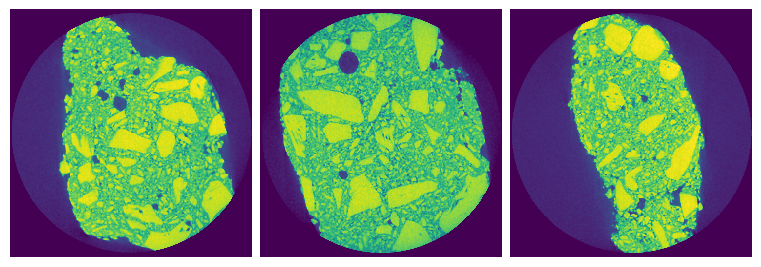

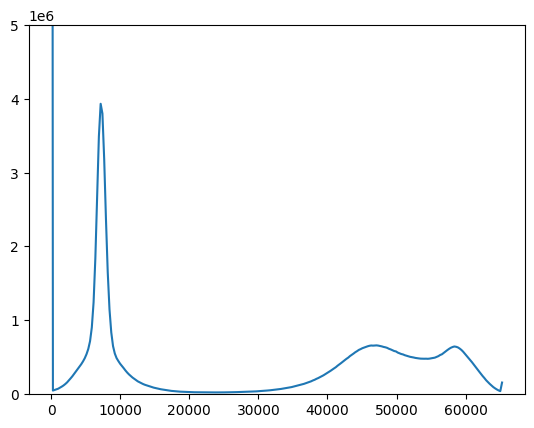

In [24]:
imgs_pre = segment.preprocess(
    imgs, rescale_intensity_range=rescale_range, median_filter=True)
fig, ax = view.vol_slices(imgs_pre, slices=slices)
figh, axh = view.histogram(imgs_pre, ylims=[0, 5e6])

Generating histogram...
Calculating voxel statistics...
--> Number of void voxels: 72309097
--> Number of binder voxels: 34577915
--> Number of particle voxels: 18593052
--> Particle to binder volume ratio: 0.5377146655603728
--> Plotting images: [100, 250, 400]


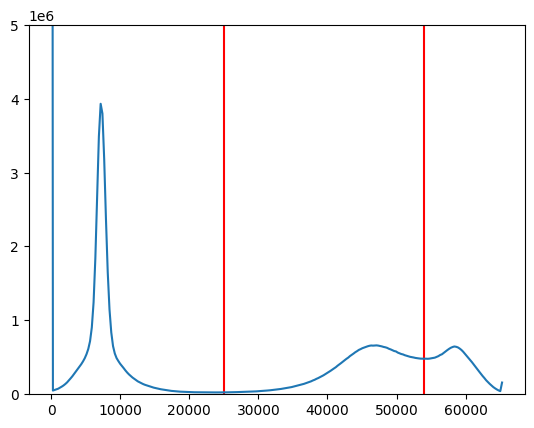

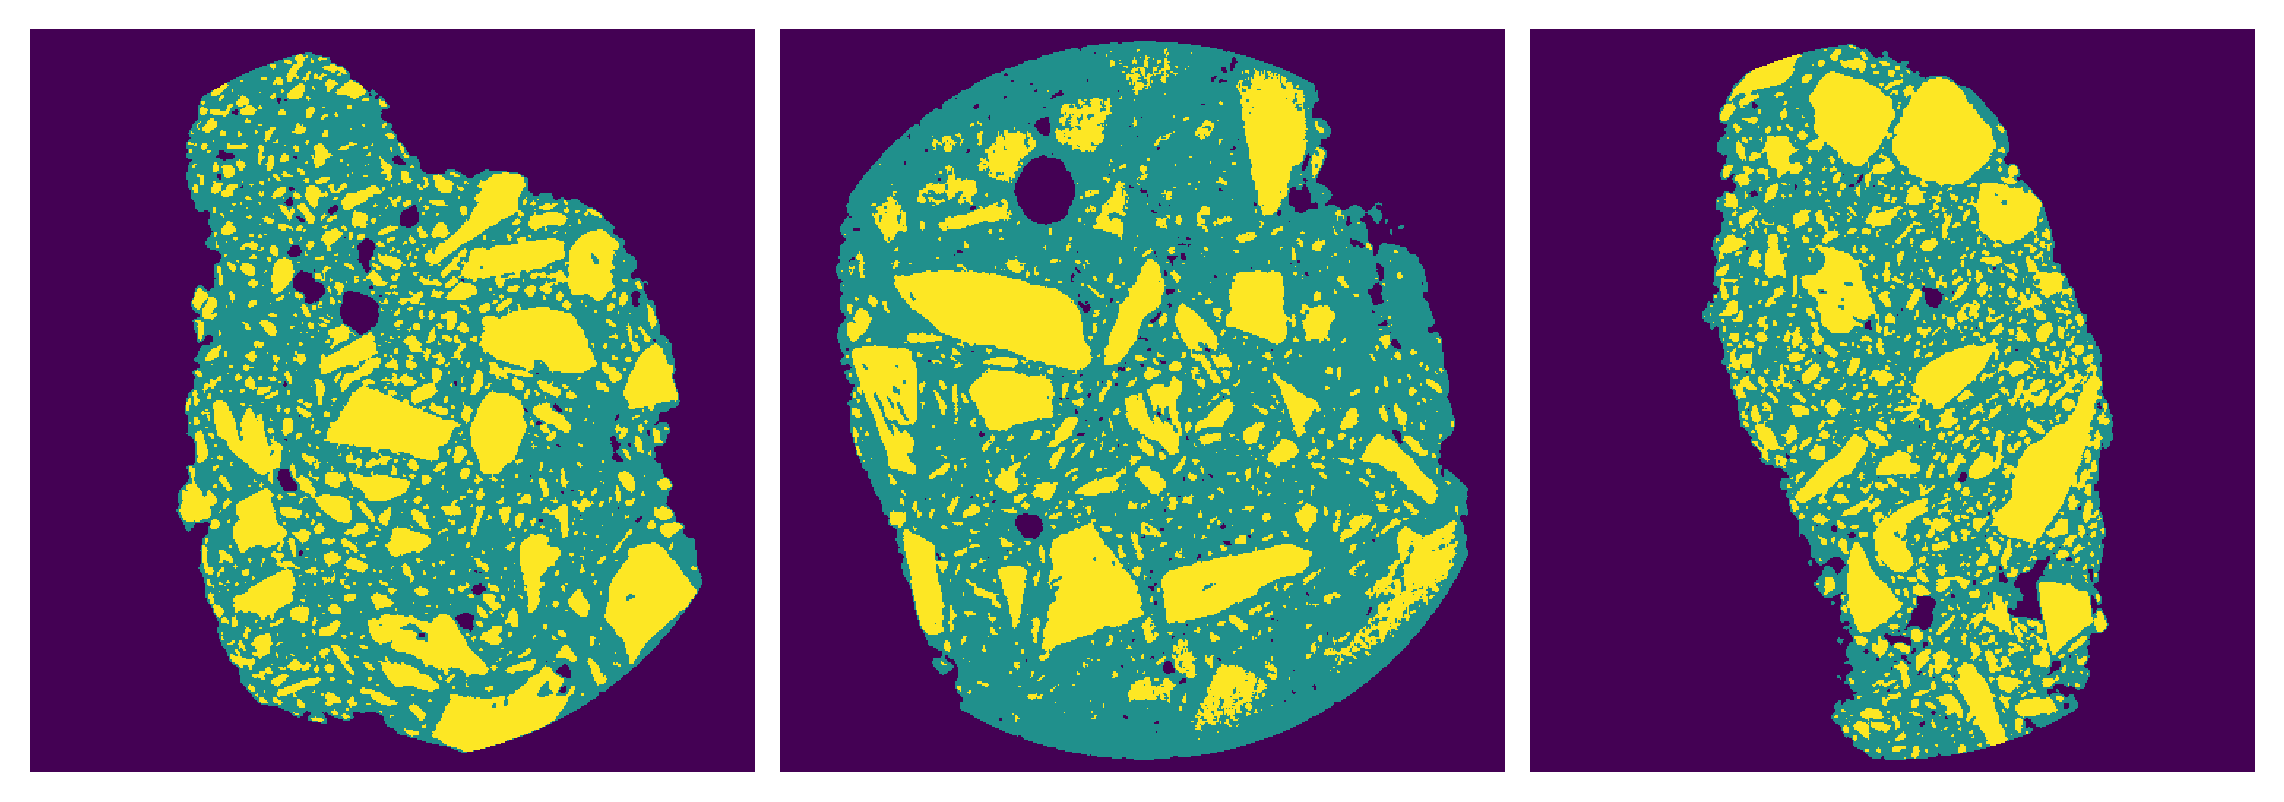

In [30]:
# Sort threshold values in descending order
thresholds = [54000, 25000]
# Calc semantic seg threshold values and generate histogram
fig, ax = view.histogram(imgs_pre, mark_values=thresholds, ylims=[0, 5e6])
# Segment images with threshold values
imgs_semantic = segment.isolate_classes(imgs_pre, thresholds)
# Calc particle to binder ratio (voxels)
particles_to_binder = segment.calc_voxel_stats(imgs_semantic)
# Generate semantic label viz
fig, axes = view.vol_slices(
    imgs_semantic, slices=slices, fig_w=7.5, dpi=300
)

Segmenting images...
--> Segmentation complete. 21663 particle(s) segmented.


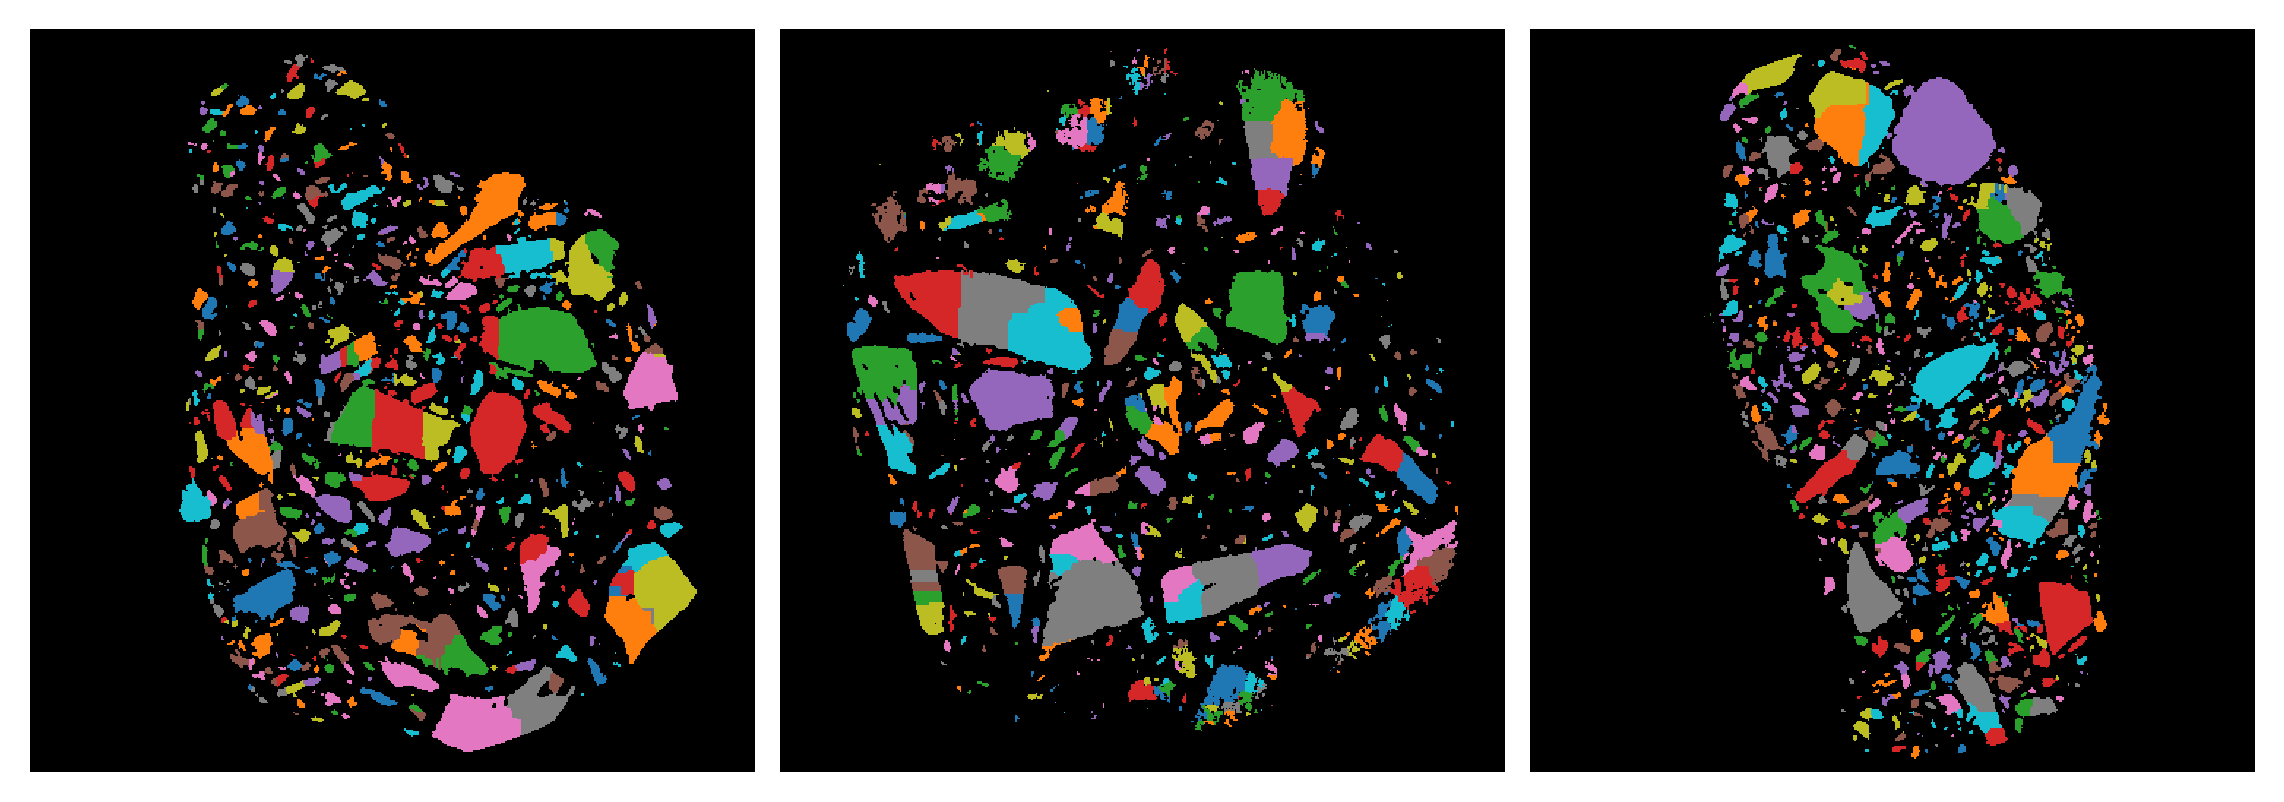

In [31]:
# Clear up memory
imgs = None
imgs_pre = None
imgs_instance = segment.watershed_segment(
    imgs_semantic==2, min_peak_distance=5, exclude_borders=False
)
# Merge semantic and instance segs to represent binder and particles
imgs_labeled = segment.merge_segmentations(
    imgs_semantic, imgs_instance)
# Generate instance label viz
fig, axes = view.color_labels(
    imgs_instance, slices=slices, fig_w=7.5, dpi=300
)